# Audio Feature Extractions

**Modified notebook from the original one made by**: [Moto Hira](https://pytorch.org/audio/stable/tutorials/audio_feature_extractions_tutorial.html)

``torchaudio`` implements feature extractions commonly used in the audio
domain. They are available in ``torchaudio.functional`` and
``torchaudio.transforms``.

``functional`` implements features as standalone functions.
They are stateless.

``transforms`` implements features as objects,
using implementations from ``functional`` and ``torch.nn.Module``.
They can be serialized using TorchScript.


In [1]:
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

2.1.1
2.1.1


## Preparation

<div class="alert alert-info"><h4>Note</h4><p>When running this tutorial in Google Colab, install the required packages

   .. code::

      !pip install librosa</p></div>




In [2]:
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

torch.random.manual_seed(0)

SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")


def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)

100%|██████████| 106k/106k [00:00<00:00, 4.71MB/s]


## Overview of audio features

The following diagram shows the relationship between common audio features
and torchaudio APIs to generate them.

<img src="https://download.pytorch.org/torchaudio/tutorial-assets/torchaudio_feature_extractions.png">

For the complete list of available features, please refer to the
documentation.




## Spectrogram

To get the frequency make-up of an audio signal as it varies with time,
you can use :py:func:`torchaudio.transforms.Spectrogram`.




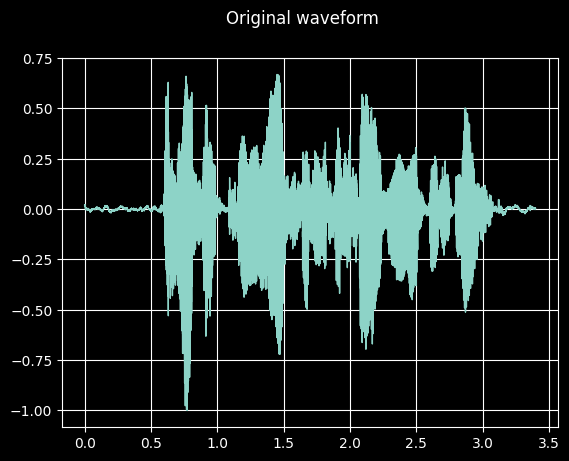

In [3]:
SPEECH_WAVEFORM, SAMPLE_RATE = torchaudio.load(SAMPLE_SPEECH)

plot_waveform(SPEECH_WAVEFORM, SAMPLE_RATE, title="Original waveform")
Audio(SPEECH_WAVEFORM.numpy(), rate=SAMPLE_RATE)

In [4]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [5]:
# Perform transform
spec = spectrogram(SPEECH_WAVEFORM)

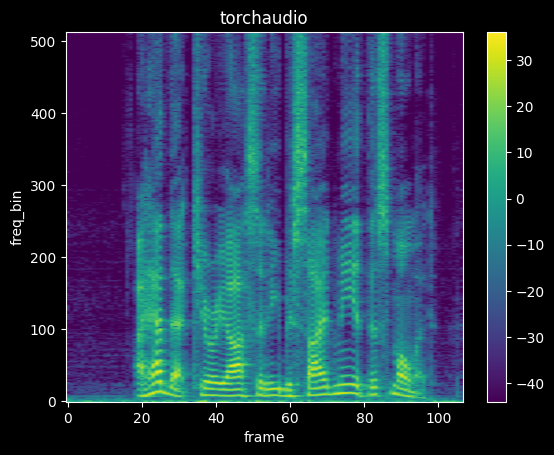

In [6]:
plot_spectrogram(spec[0], title="torchaudio")

## GriffinLim

To recover a waveform from a spectrogram, you can use ``GriffinLim``.




In [7]:
torch.random.manual_seed(0)

n_fft = 1024
win_length = None
hop_length = 512

spec = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)(SPEECH_WAVEFORM)

In [8]:
griffin_lim = T.GriffinLim(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
)

In [9]:
reconstructed_waveform = griffin_lim(spec)

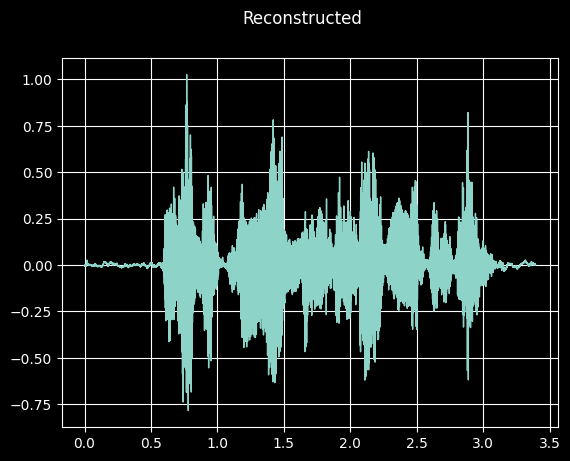

In [10]:
plot_waveform(reconstructed_waveform, SAMPLE_RATE, title="Reconstructed")
Audio(reconstructed_waveform, rate=SAMPLE_RATE)

## Mel Filter Bank

:py:func:`torchaudio.functional.melscale_fbanks` generates the filter bank
for converting frequency bins to mel-scale bins.

Since this function does not require input audio/features, there is no
equivalent transform in :py:func:`torchaudio.transforms`.




In [11]:
n_fft = 256
n_mels = 64
sample_rate = 6000

mel_filters = F.melscale_fbanks(
    int(n_fft // 2 + 1),
    n_mels=n_mels,
    f_min=0.0,
    f_max=sample_rate / 2.0,
    sample_rate=sample_rate,
    norm="slaney",
)

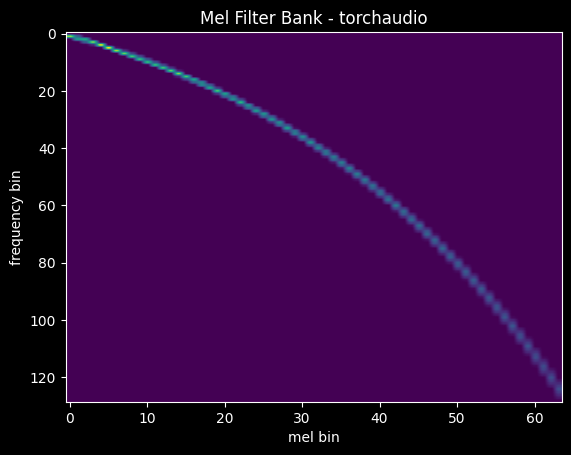

In [12]:
plot_fbank(mel_filters, "Mel Filter Bank - torchaudio")

### Comparison against librosa

For reference, here is the equivalent way to get the mel filter bank
with ``librosa``.




In [13]:
mel_filters_librosa = librosa.filters.mel(
    sr=sample_rate,
    n_fft=n_fft,
    n_mels=n_mels,
    fmin=0.0,
    fmax=sample_rate / 2.0,
    norm="slaney",
    htk=True,
).T

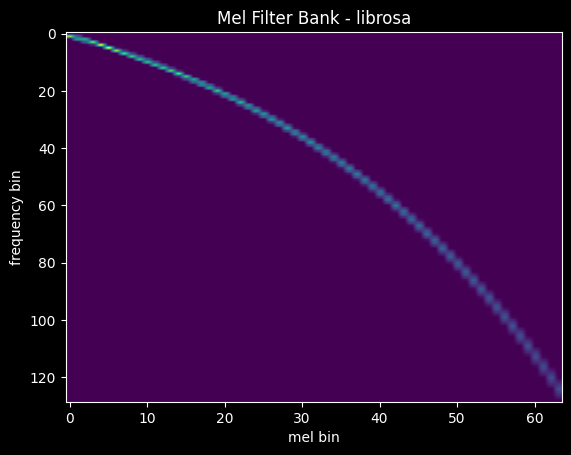

Mean Square Difference:  3.9649698287757504e-17


In [14]:
plot_fbank(mel_filters_librosa, "Mel Filter Bank - librosa")

mse = torch.square(mel_filters - mel_filters_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MelSpectrogram

Generating a mel-scale spectrogram involves generating a spectrogram
and performing mel-scale conversion. In ``torchaudio``,
:py:func:`torchaudio.transforms.MelSpectrogram` provides
this functionality.




In [15]:
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

melspec = mel_spectrogram(SPEECH_WAVEFORM)

/usr/local/Cellar/python@3.10/3.10.13_1/envs/devenv/lib/python3.10/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(


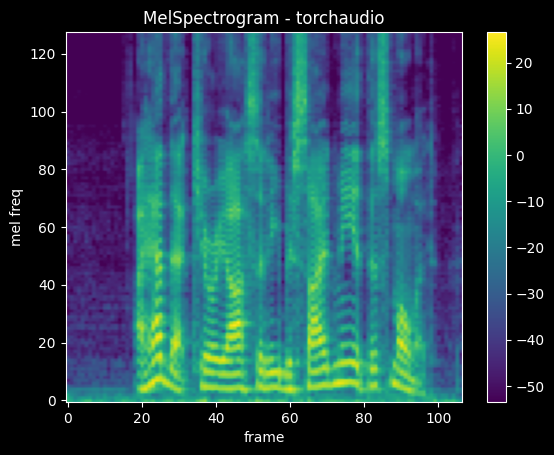

In [16]:
plot_spectrogram(melspec[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")

### Comparison against librosa

For reference, here is the equivalent means of generating mel-scale
spectrograms with ``librosa``.




In [17]:
melspec_librosa = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    n_mels=n_mels,
    norm="slaney",
    htk=True,
)

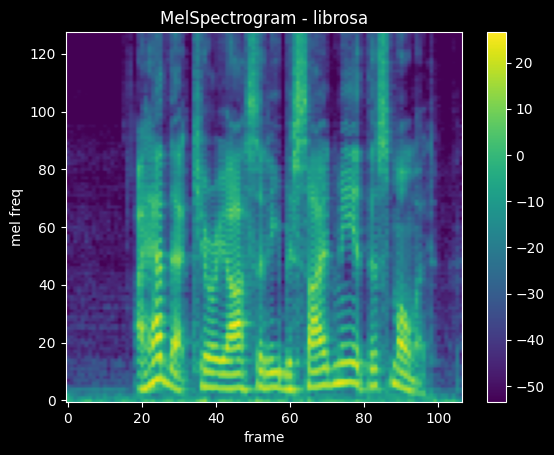

Mean Square Difference:  1.2948287997360808e-09


In [18]:
plot_spectrogram(melspec_librosa, title="MelSpectrogram - librosa", ylabel="mel freq")

mse = torch.square(melspec - melspec_librosa).mean().item()
print("Mean Square Difference: ", mse)

## MFCC




In [19]:
n_fft = 2048
win_length = None
hop_length = 512
n_mels = 256
n_mfcc = 256

mfcc_transform = T.MFCC(
    sample_rate=sample_rate,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(SPEECH_WAVEFORM)

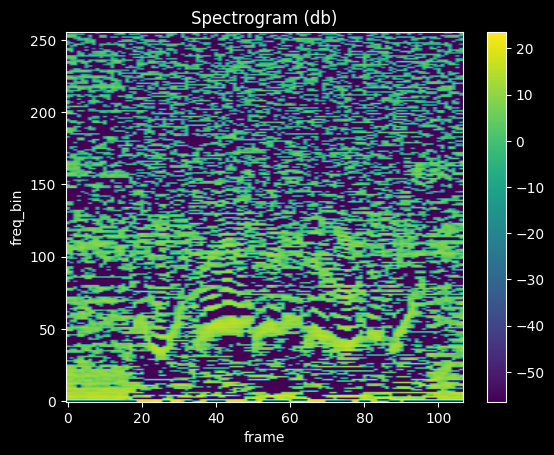

In [20]:
plot_spectrogram(mfcc[0])

### Comparison against librosa




In [21]:
melspec = librosa.feature.melspectrogram(
    y=SPEECH_WAVEFORM.numpy()[0],
    sr=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    n_mels=n_mels,
    htk=True,
    norm=None,
)

mfcc_librosa = librosa.feature.mfcc(
    S=librosa.core.spectrum.power_to_db(melspec),
    n_mfcc=n_mfcc,
    dct_type=2,
    norm="ortho",
)

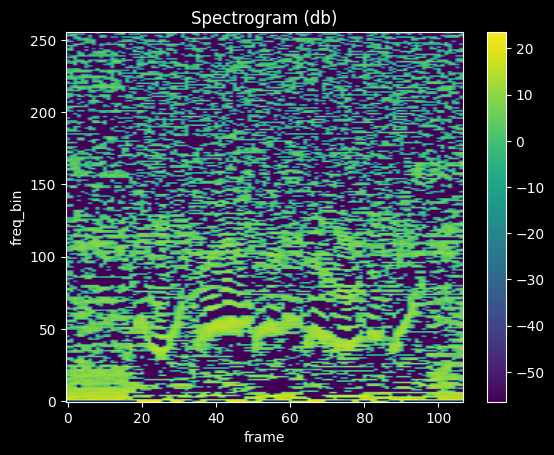

Mean Square Difference:  0.8103955984115601


In [22]:
plot_spectrogram(mfcc_librosa)

mse = torch.square(mfcc - mfcc_librosa).mean().item()
print("Mean Square Difference: ", mse)

## LFCC




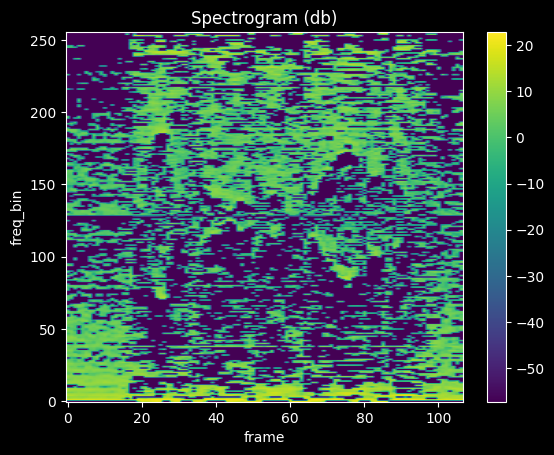

In [23]:
n_fft = 2048
win_length = None
hop_length = 512
n_lfcc = 256

lfcc_transform = T.LFCC(
    sample_rate=sample_rate,
    n_lfcc=n_lfcc,
    speckwargs={
        "n_fft": n_fft,
        "win_length": win_length,
        "hop_length": hop_length,
    },
)

lfcc = lfcc_transform(SPEECH_WAVEFORM)
plot_spectrogram(lfcc[0])

## Pitch




In [24]:
pitch = F.detect_pitch_frequency(SPEECH_WAVEFORM, SAMPLE_RATE)

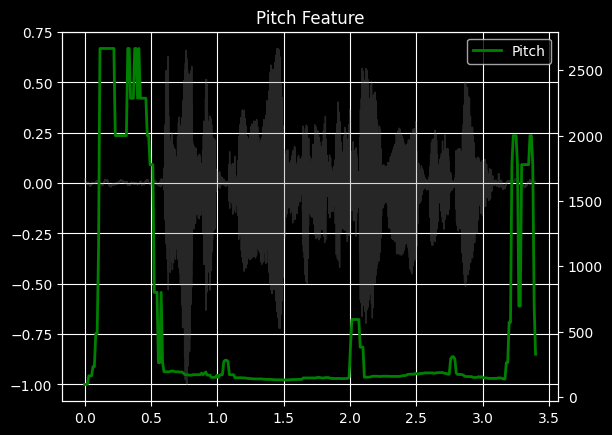

In [25]:
def plot_pitch(waveform, sr, pitch):
    figure, axis = plt.subplots(1, 1)
    axis.set_title("Pitch Feature")
    axis.grid(True)

    end_time = waveform.shape[1] / sr
    time_axis = torch.linspace(0, end_time, waveform.shape[1])
    axis.plot(time_axis, waveform[0], linewidth=1, color="gray", alpha=0.3)

    axis2 = axis.twinx()
    time_axis = torch.linspace(0, end_time, pitch.shape[1])
    axis2.plot(time_axis, pitch[0], linewidth=2, label="Pitch", color="green")

    axis2.legend(loc=0)
    plt.show(block=False)


plot_pitch(SPEECH_WAVEFORM, SAMPLE_RATE, pitch)